In [184]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("DeteccaoAnomalias") \
    .getOrCreate()

In [185]:
diretorioDataset='./temperaturas_vancouver_2023.csv'

In [186]:
data = spark.read.format("csv").options(header="true", inferschema="true").load(diretorioDataset)

In [187]:
data.show(5, False)

+----------+-----------------------+-----------------------+
|Data      |Temperatura Mínima (°C)|Temperatura Máxima (°C)|
+----------+-----------------------+-----------------------+
|2023-01-01|13.82026172983832      |24.624902571329436     |
|2023-01-02|7.0007860418361165     |16.047518573929118     |
|2023-01-03|9.893689920528697      |17.919442350361443     |
|2023-01-04|15.0                   |23.661332315530167     |
|2023-01-05|14.337789950749837     |18.697733293399804     |
+----------+-----------------------+-----------------------+
only showing top 5 rows



In [188]:
data.columns

['Data', 'Temperatura Mínima (°C)', 'Temperatura Máxima (°C)']

In [189]:
data.printSchema()

root
 |-- Data: date (nullable = true)
 |-- Temperatura Mínima (°C): double (nullable = true)
 |-- Temperatura Máxima (°C): double (nullable = true)



In [190]:
data.count()

365

In [191]:
dataAnalise=data.select('data','Temperatura Mínima (°C)', 'Temperatura Máxima (°C)')

In [192]:
dataAnalise.show(5)

+----------+-----------------------+-----------------------+
|      data|Temperatura Mínima (°C)|Temperatura Máxima (°C)|
+----------+-----------------------+-----------------------+
|2023-01-01|      13.82026172983832|     24.624902571329436|
|2023-01-02|     7.0007860418361165|     16.047518573929118|
|2023-01-03|      9.893689920528697|     17.919442350361443|
|2023-01-04|                   15.0|     23.661332315530167|
|2023-01-05|     14.337789950749837|     18.697733293399804|
+----------+-----------------------+-----------------------+
only showing top 5 rows



In [193]:
from pyspark.sql.functions import col
dataNotNull = dataAnalise.filter(col('Temperatura Mínima (°C)').isNotNull())

In [194]:
dataNotNull.show(5)

+----------+-----------------------+-----------------------+
|      data|Temperatura Mínima (°C)|Temperatura Máxima (°C)|
+----------+-----------------------+-----------------------+
|2023-01-01|      13.82026172983832|     24.624902571329436|
|2023-01-02|     7.0007860418361165|     16.047518573929118|
|2023-01-03|      9.893689920528697|     17.919442350361443|
|2023-01-04|                   15.0|     23.661332315530167|
|2023-01-05|     14.337789950749837|     18.697733293399804|
+----------+-----------------------+-----------------------+
only showing top 5 rows



In [195]:
import numpy as np
from pyspark.sql.functions import mean, stddev

In [196]:
list_stats = dataNotNull.select(mean(col('Temperatura Mínima (°C)')).alias('media'), stddev(col('Temperatura Mínima (°C)')).alias('desvioPadrao')).collect()

In [197]:
media = list_stats[0]['media']
desvio = list_stats[0]['desvioPadrao']
print("Média: ", media)
print("Desvio Padrão: ", desvio)

Média:  4.910982056932428
Desvio Padrão:  4.893435847120293


In [198]:
df_stats = dataNotNull.select(mean(col('Temperatura Mínima (°C)')).alias('media'),stddev(col('Temperatura Mínima (°C)')).alias('desvioPadrao'))
df_stats.show()

+-----------------+-----------------+
|            media|     desvioPadrao|
+-----------------+-----------------+
|4.910982056932428|4.893435847120293|
+-----------------+-----------------+



In [199]:
dataNotNull.describe().show()

+-------+-----------------------+-----------------------+
|summary|Temperatura Mínima (°C)|Temperatura Máxima (°C)|
+-------+-----------------------+-----------------------+
|  count|                    365|                    365|
|   mean|      4.910982056932428|     14.420516972928725|
| stddev|      4.893435847120293|      6.821402858562853|
|    min|     -8.862963782133251|                    0.0|
|    max|                   15.0|                   35.0|
+-------+-----------------------+-----------------------+



In [200]:
def distancia(x):
    media=56.0376399999
    desvio=26.30936160850151
    return ((x - media)/desvio)

In [201]:
def anomalias(x):
    desvio=26.30936160850151
    if (x>2):
        return 1
    else:
        return 0

In [202]:
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import udf

distancia_udf_double =udf(lambda z: distancia(z), DoubleType())
anomalia_udf_int = udf(lambda z: anomalias(z), IntegerType()) 

In [203]:
data_new = dataNotNull.select('Temperatura Mínima (°C)', distancia_udf_double('Temperatura Mínima (°C)').alias('distancia'))
data_new.show()

+-----------------------+-------------------+
|Temperatura Mínima (°C)|          distancia|
+-----------------------+-------------------+
|      13.82026172983832|-1.6046523248370919|
|     7.0007860418361165|-1.8638557137098415|
|      9.893689920528697|-1.7538985082960172|
|                   15.0|-1.5598113177569177|
|     14.337789950749837|-1.5849814476560855|
|    0.11361060061794515|-2.1256323217364184|
|      9.750442087627947|-1.7593432558741744|
|      4.243213958511511|-1.9686690544650778|
|      4.483905741032211| -1.959520532121498|
|      7.052992509691862|-1.8618713832409912|
|       5.72021785580439|-1.9125291937086082|
|     12.271367534814875| -1.663524684344399|
|      8.805188625734967|-1.7952716632585457|
|      5.608375082464142|-1.9167802574555943|
|      7.219316163727129|-1.8555495402213749|
|      6.668371636871334|-1.8764905472687585|
|      12.47039536578803|-1.6559597789721288|
|     3.9742086811709956|-1.9788937524772712|
|      6.565338508254507|-1.880406

In [204]:
from pyspark.sql.functions import abs
data_new=data_new.select('Temperatura Mínima (°C)', 'distancia', abs(col('distancia')).alias('distanciaABS'))
data_new.show()

+-----------------------+-------------------+------------------+
|Temperatura Mínima (°C)|          distancia|      distanciaABS|
+-----------------------+-------------------+------------------+
|      13.82026172983832|-1.6046523248370919|1.6046523248370919|
|     7.0007860418361165|-1.8638557137098415|1.8638557137098415|
|      9.893689920528697|-1.7538985082960172|1.7538985082960172|
|                   15.0|-1.5598113177569177|1.5598113177569177|
|     14.337789950749837|-1.5849814476560855|1.5849814476560855|
|    0.11361060061794515|-2.1256323217364184|2.1256323217364184|
|      9.750442087627947|-1.7593432558741744|1.7593432558741744|
|      4.243213958511511|-1.9686690544650778|1.9686690544650778|
|      4.483905741032211| -1.959520532121498| 1.959520532121498|
|      7.052992509691862|-1.8618713832409912|1.8618713832409912|
|       5.72021785580439|-1.9125291937086082|1.9125291937086082|
|     12.271367534814875| -1.663524684344399| 1.663524684344399|
|      8.805188625734967|

In [205]:
data_new=data_new.select('Temperatura Mínima (°C)', 'distancia', 'distanciaABS', anomalia_udf_int('distanciaABS').alias('isAnomaly'))
data_new.show()

+-----------------------+-------------------+------------------+---------+
|Temperatura Mínima (°C)|          distancia|      distanciaABS|isAnomaly|
+-----------------------+-------------------+------------------+---------+
|      13.82026172983832|-1.6046523248370919|1.6046523248370919|        0|
|     7.0007860418361165|-1.8638557137098415|1.8638557137098415|        0|
|      9.893689920528697|-1.7538985082960172|1.7538985082960172|        0|
|                   15.0|-1.5598113177569177|1.5598113177569177|        0|
|     14.337789950749837|-1.5849814476560855|1.5849814476560855|        0|
|    0.11361060061794515|-2.1256323217364184|2.1256323217364184|        1|
|      9.750442087627947|-1.7593432558741744|1.7593432558741744|        0|
|      4.243213958511511|-1.9686690544650778|1.9686690544650778|        0|
|      4.483905741032211| -1.959520532121498| 1.959520532121498|        0|
|      7.052992509691862|-1.8618713832409912|1.8618713832409912|        0|
|       5.72021785580439|

In [206]:
data_new.filter(col('isAnomaly')>0).show()

+-----------------------+-------------------+------------------+---------+
|Temperatura Mínima (°C)|          distancia|      distanciaABS|isAnomaly|
+-----------------------+-------------------+------------------+---------+
|    0.11361060061794515|-2.1256323217364184|2.1256323217364184|        1|
|     0.7295213034913761| -2.102221996847562| 2.102221996847562|        1|
|     -7.764949079170393|-2.4250907349440762|2.4250907349440762|        1|
|     1.2891748979677904| -2.080949964374696| 2.080949964374696|        1|
|    -2.2718283729938236|-2.2163011493996843|2.2163011493996843|        1|
|     0.5610712618494365|-2.1086246623378377|2.1086246623378377|        1|
|     -4.903982341119635|-2.3163474373824102|2.3163474373824102|        1|
|      3.260439253369237|-2.0060236174440864|2.0060236174440864|        1|
|     3.0633659129602386| -2.013514234029223| 2.013514234029223|        1|
|   -0.24276482533546329| -2.139177896549539| 2.139177896549539|        1|
|    -2.1000896858948757|

         Data  Temperatura Mínima (°C)  Temperatura Máxima (°C)
0  2023-01-01                13.820262                24.624903
1  2023-01-02                 7.000786                16.047519
2  2023-01-03                 9.893690                17.919442
3  2023-01-04                15.000000                23.661332
4  2023-01-05                14.337790                18.697733


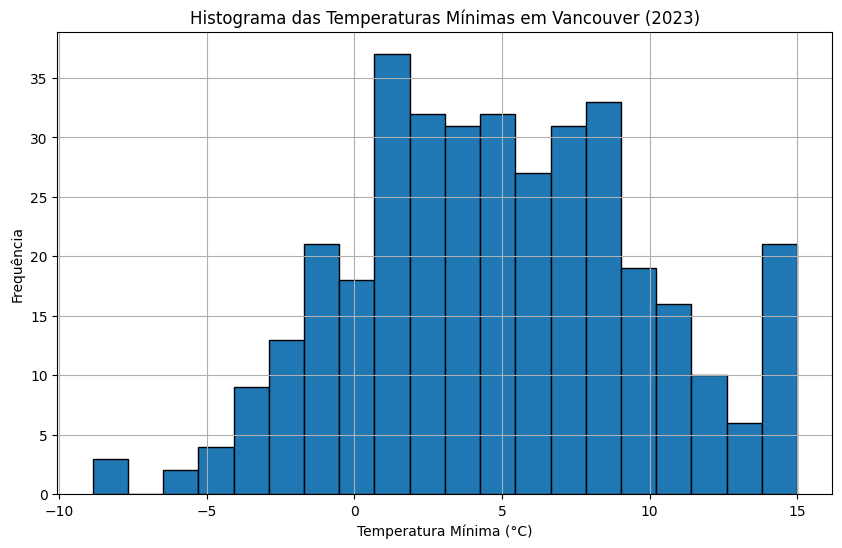

In [207]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
file_path = './temperaturas_vancouver_2023.csv'
df = pd.read_csv(file_path)

# Exibir as primeiras linhas do DataFrame para garantir que os dados foram carregados corretamente
print(df.head())

plt.figure(figsize=(10, 6))
plt.hist(df['Temperatura Mínima (°C)'], bins=20, edgecolor='black')
plt.title('Histograma das Temperaturas Mínimas em Vancouver (2023)')
plt.xlabel('Temperatura Mínima (°C)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [208]:
display(dataNotNull.select('Temperatura Mínima (°C)'))

DataFrame[Temperatura Mínima (°C): double]

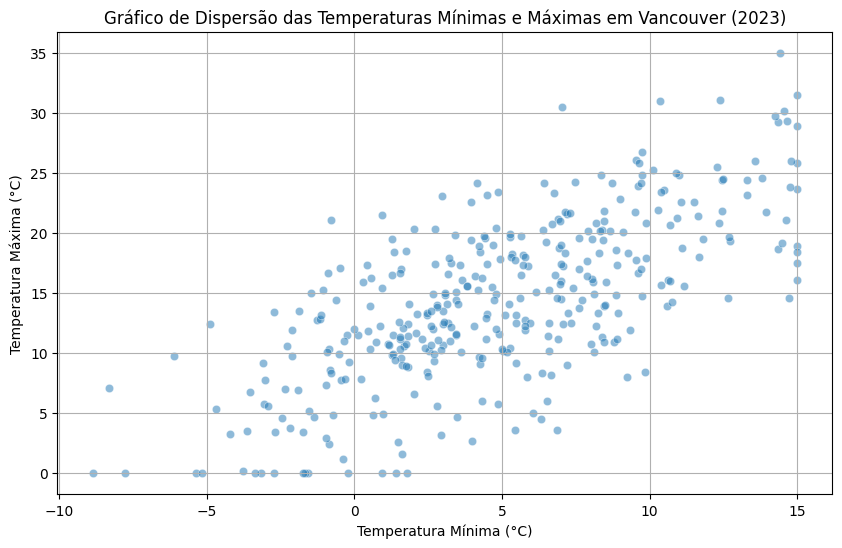

In [209]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Temperatura Mínima (°C)'], df['Temperatura Máxima (°C)'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.title('Gráfico de Dispersão das Temperaturas Mínimas e Máximas em Vancouver (2023)')
plt.xlabel('Temperatura Mínima (°C)')
plt.ylabel('Temperatura Máxima (°C)')
plt.grid(True)
plt.show()

In [210]:
from pyspark.mllib.stat import Statistics
coluna=dataNotNull.select('Temperatura Mínima (°C)')
coluna1=coluna.rdd.map(lambda x: [int (x[0])])
estatistica=Statistics.colStats(coluna1)
print("Média: ", estatistica.mean())
print("Variância: ", estatistica.variance())
print("Valores não nulos: ", estatistica.numNonzeros())

Média:  [4.58082192]
Variância:  [21.94193888]
Valores não nulos:  [328.]


////////////WORLD-CITIES//////////////

In [211]:
diretorioDataset="./worldcities.csv"

In [212]:
cities_df = spark.read.format("csv").options(header="true", inferschema="true").load(diretorioDataset)

In [213]:
cities_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- city_ascii: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- country: string (nullable = true)
 |-- iso2: string (nullable = true)
 |-- iso3: string (nullable = true)
 |-- admin_name: string (nullable = true)
 |-- capital: string (nullable = true)
 |-- population: double (nullable = true)
 |-- id: integer (nullable = true)



In [214]:
cities_df.show()

+------------+------------+--------+--------+-------------+----+----+--------------------+-------+-----------+----------+
|        city|  city_ascii|     lat|     lng|      country|iso2|iso3|          admin_name|capital| population|        id|
+------------+------------+--------+--------+-------------+----+----+--------------------+-------+-----------+----------+
|       Tokyo|       Tokyo| 35.6897|139.6922|        Japan|  JP| JPN|               Tōkyō|primary|   3.7732E7|1392685764|
|     Jakarta|     Jakarta|  -6.175|106.8275|    Indonesia|  ID| IDN|             Jakarta|primary|   3.3756E7|1360771077|
|       Delhi|       Delhi|   28.61|   77.23|        India|  IN| IND|               Delhi|  admin|   3.2226E7|1356872604|
|   Guangzhou|   Guangzhou|   23.13|  113.26|        China|  CN| CHN|           Guangdong|  admin|    2.694E7|1156237133|
|      Mumbai|      Mumbai| 19.0761| 72.8775|        India|  IN| IND|         Mahārāshtra|  admin|   2.4973E7|1356226629|
|      Manila|      Mani

In [215]:
cities_BR = cities_df.where(col("country")=="Brazil")
cities_BR.show(10)

+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|      admin_name|capital|population|        id|
+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|       São Paulo|  admin|  2.3086E7|1076532519|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|  Rio de Janeiro|  admin|  1.2592E7|1076887657|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|    Minas Gerais|  admin| 5328000.0|1076967355|
|     Fortaleza|     Fortaleza| -3.7275|-38.5275| Brazil|  BR| BRA|           Ceará|  admin| 4167996.0|1076567885|
|      Brasília|      Brasilia|-15.7939|-47.8828| Brazil|  BR| BRA|Distrito Federal|primary| 2817068.0|1076144436|
|      Salvador|      Salvador|-12.9747|-38.4767| Brazil|  BR| BRA|           Ba

In [216]:
cities_MX = cities_df.where(col("country")=="Mexico")
cities_MX.show(10)

+------------------+------------------+-------+---------+-------+----+----+----------------+-------+----------+----------+
|              city|        city_ascii|    lat|      lng|country|iso2|iso3|      admin_name|capital|population|        id|
+------------------+------------------+-------+---------+-------+----+----+----------------+-------+----------+----------+
|       Mexico City|       Mexico City|19.4333| -99.1333| Mexico|  MX| MEX|Ciudad de México|primary|  2.1804E7|1484247881|
|       Guadalajara|       Guadalajara|20.6767|-103.3475| Mexico|  MX| MEX|         Jalisco|  admin| 5525000.0|1484950208|
|         Monterrey|         Monterrey|25.6667|   -100.3| Mexico|  MX| MEX|      Nuevo León|  admin| 5341171.0|1484559591|
|           Tijuana|           Tijuana| 32.525|-117.0333| Mexico|  MX| MEX| Baja California|  minor| 2002000.0|1484708778|
|          Ecatepec|          Ecatepec|19.6097|   -99.06| Mexico|  MX| MEX|          México|  minor| 1929926.0|1484003694|
|León de los Ald

In [217]:
cities_USA = cities_df.where(col("country")=="United States")
cities_USA.show(5)

+-----------+-----------+-------+---------+-------------+----+----+----------+-------+-----------+----------+
|       city| city_ascii|    lat|      lng|      country|iso2|iso3|admin_name|capital| population|        id|
+-----------+-----------+-------+---------+-------------+----+----+----------+-------+-----------+----------+
|   New York|   New York|40.6943| -73.9249|United States|  US| USA|  New York|   NULL|1.8908608E7|1840034016|
|Los Angeles|Los Angeles|34.1141|-118.4068|United States|  US| USA|California|   NULL|1.1922389E7|1840020491|
|    Chicago|    Chicago|41.8375| -87.6866|United States|  US| USA|  Illinois|   NULL|  8497759.0|1840000494|
|      Miami|      Miami| 25.784| -80.2101|United States|  US| USA|   Florida|   NULL|  6080145.0|1840015149|
|    Houston|    Houston| 29.786| -95.3885|United States|  US| USA|     Texas|   NULL|  5970127.0|1840020925|
+-----------+-----------+-------+---------+-------------+----+----+----------+-------+-----------+----------+
only showi

In [218]:
cities_JP = cities_df.where(col("country")=="Japan")
cities_JP.show(5)

+--------+----------+-------+--------+-------+----+----+----------+-------+----------+----------+
|    city|city_ascii|    lat|     lng|country|iso2|iso3|admin_name|capital|population|        id|
+--------+----------+-------+--------+-------+----+----+----------+-------+----------+----------+
|   Tokyo|     Tokyo|35.6897|139.6922|  Japan|  JP| JPN|     Tōkyō|primary|  3.7732E7|1392685764|
|   Ōsaka|     Osaka|34.6939|135.5022|  Japan|  JP| JPN|     Ōsaka|  admin|  1.5126E7|1392419823|
|  Nagoya|    Nagoya|35.1833|   136.9|  Japan|  JP| JPN|     Aichi|  admin| 9197000.0|1392407472|
|Yokohama|  Yokohama|35.4442|139.6381|  Japan|  JP| JPN|  Kanagawa|  admin| 3757630.0|1392118339|
| Fukuoka|   Fukuoka|  33.59|130.4017|  Japan|  JP| JPN|   Fukuoka|  admin| 2286000.0|1392576294|
+--------+----------+-------+--------+-------+----+----+----------+-------+----------+----------+
only showing top 5 rows



In [219]:
df_concat = cities_BR.union(cities_MX)
df_concat.show(5)

+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|      admin_name|capital|population|        id|
+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|       São Paulo|  admin|  2.3086E7|1076532519|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|  Rio de Janeiro|  admin|  1.2592E7|1076887657|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|    Minas Gerais|  admin| 5328000.0|1076967355|
|     Fortaleza|     Fortaleza| -3.7275|-38.5275| Brazil|  BR| BRA|           Ceará|  admin| 4167996.0|1076567885|
|      Brasília|      Brasilia|-15.7939|-47.8828| Brazil|  BR| BRA|Distrito Federal|primary| 2817068.0|1076144436|
+--------------+--------------+--------+--------+-------+----+----+-------------

In [220]:
df_concat.groupBy("country").count().show()

+-------+-----+
|country|count|
+-------+-----+
| Brazil| 2937|
| Mexico|  983|
+-------+-----+



In [221]:
cities_JP = cities_df.where((col("city")=="Tokyo") | (col("city")=="Ōsaka"))
cities_JP.show()

+-----+----------+-------+--------+-------+----+----+----------+-------+----------+----------+
| city|city_ascii|    lat|     lng|country|iso2|iso3|admin_name|capital|population|        id|
+-----+----------+-------+--------+-------+----+----+----------+-------+----------+----------+
|Tokyo|     Tokyo|35.6897|139.6922|  Japan|  JP| JPN|     Tōkyō|primary|  3.7732E7|1392685764|
|Ōsaka|     Osaka|34.6939|135.5022|  Japan|  JP| JPN|     Ōsaka|  admin|  1.5126E7|1392419823|
+-----+----------+-------+--------+-------+----+----+----------+-------+----------+----------+



In [222]:
df_final = df_concat.union(cities_JP)
df_final.show()

+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|        admin_name|capital|population|        id|
+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|         São Paulo|  admin|  2.3086E7|1076532519|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|    Rio de Janeiro|  admin|  1.2592E7|1076887657|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|      Minas Gerais|  admin| 5328000.0|1076967355|
|     Fortaleza|     Fortaleza| -3.7275|-38.5275| Brazil|  BR| BRA|             Ceará|  admin| 4167996.0|1076567885|
|      Brasília|      Brasilia|-15.7939|-47.8828| Brazil|  BR| BRA|  Distrito Federal|primary| 2817068.0|1076144436|
|      Salvador|      Salvador|-12.9747|-38.4767| Brazil|  BR| B

In [223]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler



In [224]:
from pyspark.ml.feature import VectorAssembler

VectorAssembler = VectorAssembler(inputCols=["lat", "lng"], outputCol="features")
new_df = VectorAssembler.transform(df_final)
new_df.show()

+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+-------------------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|        admin_name|capital|population|        id|           features|
+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+-------------------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|         São Paulo|  admin|  2.3086E7|1076532519|  [-23.55,-46.6333]|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|    Rio de Janeiro|  admin|  1.2592E7|1076887657|[-22.9111,-43.2056]|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|      Minas Gerais|  admin| 5328000.0|1076967355|[-19.9167,-43.9333]|
|     Fortaleza|     Fortaleza| -3.7275|-38.5275| Brazil|  BR| BRA|             Ceará|  admin| 4167996.0|1076567885| [-3.7275,-38.5275]|
|      Brasília|      Brasilia|-15.7939|-

In [225]:
KMeans = KMeans(k=3, seed=1)
model = KMeans.fit(new_df.select('features'))

In [226]:
df_final = model.transform(new_df)
df_final.show()

+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+-------------------+----------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|        admin_name|capital|population|        id|           features|prediction|
+--------------+--------------+--------+--------+-------+----+----+------------------+-------+----------+----------+-------------------+----------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|         São Paulo|  admin|  2.3086E7|1076532519|  [-23.55,-46.6333]|         0|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|    Rio de Janeiro|  admin|  1.2592E7|1076887657|[-22.9111,-43.2056]|         0|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|      Minas Gerais|  admin| 5328000.0|1076967355|[-19.9167,-43.9333]|         0|
|     Fortaleza|     Fortaleza| -3.7275|-38.5275| Brazil|  BR| BRA|             Ceará|  admin| 4167996.0|1076567

In [227]:
df_final.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2| 1355|
|         0| 1584|
|         1|  983|
+----------+-----+



In [228]:
df_final.where(col("prediction")=='0').show(5)

+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+-------------------+----------+
|          city|    city_ascii|     lat|     lng|country|iso2|iso3|      admin_name|capital|population|        id|           features|prediction|
+--------------+--------------+--------+--------+-------+----+----+----------------+-------+----------+----------+-------------------+----------+
|     São Paulo|     Sao Paulo|  -23.55|-46.6333| Brazil|  BR| BRA|       São Paulo|  admin|  2.3086E7|1076532519|  [-23.55,-46.6333]|         0|
|Rio de Janeiro|Rio de Janeiro|-22.9111|-43.2056| Brazil|  BR| BRA|  Rio de Janeiro|  admin|  1.2592E7|1076887657|[-22.9111,-43.2056]|         0|
|Belo Horizonte|Belo Horizonte|-19.9167|-43.9333| Brazil|  BR| BRA|    Minas Gerais|  admin| 5328000.0|1076967355|[-19.9167,-43.9333]|         0|
|      Brasília|      Brasilia|-15.7939|-47.8828| Brazil|  BR| BRA|Distrito Federal|primary| 2817068.0|1076144436|[-15.7939,